In [368]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import math
import tensorflow
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error
import seaborn as sns
import pickle

In [369]:
data = pd.read_csv('Potato.csv')

In [370]:
#Drop na's.
data.dropna(axis=0, inplace=True) #remove all rows with na's.
data.reset_index(drop=True)

,Date,Centre_Name,Commodity_Name,Price
0,2001-01-01,DELHI,Potato,3.0
1,2001-01-01,MUMBAI,Potato,5.5
2,2001-01-01,KOLKATA,Potato,2.5
3,2001-01-02,DELHI,Potato,7.0
4,2001-01-02,MUMBAI,Potato,10.5
...,...,...,...,...
5076,2015-12-11,MUMBAI,Potato,13.0
5077,2015-12-11,KOLKATA,Potato,6.0
5078,2015-12-14,DELHI,Potato,18.0
5079,2015-12-14,MUMBAI,Potato,31.0


In [371]:
#calculate average price for each centre for each day 
data_gp = data.sort_values('Date').groupby(['Centre_Name', 'Date'], as_index=False)
data_gp = data_gp.agg({'Price':['mean']})
data_gp.columns = ['Centre_Name', 'Date', 'Price']
data_gp.head()

,Centre_Name,Date,Price
0,DELHI,2001-01-01,3.0
1,DELHI,2001-01-02,7.0
2,DELHI,2001-01-03,5.0
3,DELHI,2001-01-04,4.0
4,DELHI,2001-01-08,9.0


In [372]:
#centre_1_train_dataset
centre_1_data = data_gp.loc[(data_gp['Centre_Name']=="DELHI"),["Price"]].values
centre_1_data = centre_1_data.astype("float32")

#centre_2_train_dataset
centre_2_data = data_gp.loc[(data_gp['Centre_Name']=="KOLKATA"),["Price"]].values
centre_2_data = centre_2_data.astype("float32")

#centre_2_train_dataset
centre_3_data = data_gp.loc[(data_gp['Centre_Name']=="MUMBAI"),["Price"]].values
centre_3_data = centre_3_data.astype("float32")

print(centre_1_data.size,centre_2_data.size,centre_3_data.size)

1708 1677 1696


In [373]:
#take last year as test dataset
train_centre_1 = centre_1_data[:-365]
test_centre_1 = centre_1_data[-365:]

train_centre_2 = centre_2_data[:-365]
test_centre_2 = centre_2_data[-365:]

train_centre_3 = centre_3_data[:-365]
test_centre_3 = centre_3_data[-365:]

print("train size: {}, test size: {}".format(len(train_centre_1), len(test_centre_1)))

train size: 1343, test size: 365


In [374]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#transform the data using minmax scaler
scaler_2 = MinMaxScaler(feature_range=(0,1))
scaler_3 = MinMaxScaler(feature_range=(0,1))

train_centre_1 = scaler.fit_transform(train_centre_1)
test_centre_1 = scaler.transform(test_centre_1)

train_centre_2 = scaler_2.fit_transform(train_centre_2)
test_centre_2 = scaler_2.transform(test_centre_2)

train_centre_3 = scaler_3.fit_transform(train_centre_3)
test_centre_3 = scaler_3.transform(test_centre_3)

In [375]:
#train:

time_step = 30
datax_centre_1=[]
datay_centre_1=[]

for i in range(len(train_centre_1)-time_step-1):
    datax_centre_1.append(train_centre_1[i:(i+time_step),0])
    datay_centre_1.append(train_centre_1[i+time_step,0])
trainx_centre_1=np.array(datax_centre_1)
trainy_centre_1=np.array(datay_centre_1)

datax_centre_2=[]
datay_centre_2=[]

for i in range(len(train_centre_2)-time_step-1):
    datax_centre_2.append(train_centre_2[i:(i+time_step),0])
    datay_centre_2.append(train_centre_2[i+time_step,0])
trainx_centre_2=np.array(datax_centre_2)
trainy_centre_2=np.array(datay_centre_2)

datax_centre_3=[]
datay_centre_3=[]

for i in range(len(train_centre_3)-time_step-1):
    datax_centre_3.append(train_centre_3[i:(i+time_step),0])
    datay_centre_3.append(train_centre_3[i+time_step,0])
trainx_centre_3=np.array(datax_centre_3)
trainy_centre_3=np.array(datay_centre_3)

In [376]:
#test:

datax_centre_1=[]
datay_centre_1=[]

for i in range(len(test_centre_1)-time_step-1):
    datax_centre_1.append(test_centre_1[i:(i+time_step),0])
    datay_centre_1.append(test_centre_1[i+time_step,0])
testx_centre_1=np.array(datax_centre_1)
testy_centre_1=np.array(datay_centre_1)


datax_centre_2=[]
datay_centre_2=[]

for i in range(len(test_centre_2)-time_step-1):
    datax_centre_2.append(test_centre_2[i:(i+time_step),0])
    datay_centre_2.append(test_centre_2[i+time_step,0])
testx_centre_2=np.array(datax_centre_2)
testy_centre_2=np.array(datay_centre_2)

datax_centre_3=[]
datay_centre_3=[]

for i in range(len(test_centre_3)-time_step-1):
    datax_centre_3.append(test_centre_3[i:(i+time_step),0])
    datay_centre_3.append(test_centre_3[i+time_step,0])
testx_centre_3=np.array(datax_centre_3)
testy_centre_3=np.array(datay_centre_3)

In [377]:
trainx_centre_1=np.reshape(trainx_centre_1, (trainx_centre_1.shape[0],1,trainx_centre_1.shape[1]))
testx_centre_1=np.reshape(testx_centre_1, (testx_centre_1.shape[0],1,testx_centre_1.shape[1]))

trainx_centre_2=np.reshape(trainx_centre_2, (trainx_centre_2.shape[0],1,trainx_centre_2.shape[1]))
testx_centre_2=np.reshape(testx_centre_2, (testx_centre_2.shape[0],1,testx_centre_2.shape[1]))

trainx_centre_3=np.reshape(trainx_centre_3, (trainx_centre_3.shape[0],1,trainx_centre_3.shape[1]))
testx_centre_3=np.reshape(testx_centre_3, (testx_centre_3.shape[0],1,testx_centre_3.shape[1]))


In [378]:
model =Sequential()
model.add(LSTM(20, input_shape=(1, time_step))) #20 LSTM neuron
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history_1 = model.fit(trainx_centre_1, trainy_centre_1, epochs=100, batch_size=32,    validation_split=0.1, shuffle=False)

Epoch 1/100
37/37 [==============================] - 0s 10ms/step - loss: 0.9344 - val_loss: 0.8388
Epoch 2/100
37/37 [==============================] - 0s 2ms/step - loss: 0.7848 - val_loss: 0.7210
Epoch 3/100
37/37 [==============================] - 0s 3ms/step - loss: 0.7110 - val_loss: 0.6541
Epoch 4/100
37/37 [==============================] - 0s 2ms/step - loss: 0.6637 - val_loss: 0.6092
Epoch 5/100
37/37 [==============================] - 0s 2ms/step - loss: 0.6292 - val_loss: 0.5773
Epoch 6/100
37/37 [==============================] - 0s 2ms/step - loss: 0.6027 - val_loss: 0.5542
Epoch 7/100
37/37 [==============================] - 0s 2ms/step - loss: 0.5816 - val_loss: 0.5373
Epoch 8/100
37/37 [==============================] - 0s 2ms/step - loss: 0.5639 - val_loss: 0.5244
Epoch 9/100
37/37 [==============================] - 0s 2ms/step - loss: 0.5484 - val_loss: 0.5141
Epoch 10/100
37/37 [==============================] - 0s 3ms/step - loss: 0.5342 - val_loss: 0.5056
Epoch 11

37/37 [==============================] - 0s 2ms/step - loss: 0.1398 - val_loss: 0.3318
Epoch 84/100
37/37 [==============================] - 0s 2ms/step - loss: 0.1378 - val_loss: 0.3315
Epoch 85/100
37/37 [==============================] - 0s 2ms/step - loss: 0.1359 - val_loss: 0.3311
Epoch 86/100
37/37 [==============================] - 0s 2ms/step - loss: 0.1339 - val_loss: 0.3308
Epoch 87/100
37/37 [==============================] - 0s 2ms/step - loss: 0.1320 - val_loss: 0.3306
Epoch 88/100
37/37 [==============================] - 0s 2ms/step - loss: 0.1302 - val_loss: 0.3303
Epoch 89/100
37/37 [==============================] - 0s 2ms/step - loss: 0.1283 - val_loss: 0.3301
Epoch 90/100
37/37 [==============================] - 0s 2ms/step - loss: 0.1265 - val_loss: 0.3299
Epoch 91/100
37/37 [==============================] - 0s 2ms/step - loss: 0.1247 - val_loss: 0.3298
Epoch 92/100
37/37 [==============================] - 0s 2ms/step - loss: 0.1230 - val_loss: 0.3297
Epoch 93/100


In [379]:
model_2 =Sequential()
model_2.add(LSTM(20, input_shape=(1, time_step))) #20 LSTM neuron
model_2.add(Dense(1))
model_2.compile(loss='mean_squared_error', optimizer='adam')
history_2 = model.fit(trainx_centre_2, trainy_centre_2, epochs=100, batch_size=32,   validation_split=0.1, shuffle=False)

Epoch 1/100
36/36 [==============================] - 0s 3ms/step - loss: 0.2820 - val_loss: 0.0829
Epoch 2/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0620 - val_loss: 0.0547
Epoch 3/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0480
Epoch 4/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0417 - val_loss: 0.0438
Epoch 5/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0410
Epoch 6/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0390
Epoch 7/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.0377
Epoch 8/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0367
Epoch 9/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0359
Epoch 10/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.0354
Epoch 11/

36/36 [==============================] - 0s 3ms/step - loss: 0.0233 - val_loss: 0.0300
Epoch 84/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0299
Epoch 85/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0299
Epoch 86/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0299
Epoch 87/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0299
Epoch 88/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0299
Epoch 89/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0299
Epoch 90/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0299
Epoch 91/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0299
Epoch 92/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0299
Epoch 93/100


In [380]:
model_3 =Sequential()
model_3.add(LSTM(20, input_shape=(1, time_step))) #20 LSTM neuron
model_3.add(Dense(1))
model_3.compile(loss='mean_squared_error', optimizer='adam')
history_3 = model.fit(trainx_centre_3, trainy_centre_3, epochs=100, batch_size=32,  validation_split=0.1, shuffle=False) 

Epoch 1/100
37/37 [==============================] - 0s 3ms/step - loss: 0.0381 - val_loss: 0.0317
Epoch 2/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0311
Epoch 3/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.0307
Epoch 4/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0304
Epoch 5/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0302
Epoch 6/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.0300
Epoch 7/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.0297
Epoch 8/100
37/37 [==============================] - 0s 3ms/step - loss: 0.0312 - val_loss: 0.0295
Epoch 9/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0293
Epoch 10/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0305 - val_loss: 0.0291
Epoch 11/

37/37 [==============================] - 0s 3ms/step - loss: 0.0224 - val_loss: 0.0260
Epoch 84/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0260
Epoch 85/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0260
Epoch 86/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0260
Epoch 87/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0260
Epoch 88/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0260
Epoch 89/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0260
Epoch 90/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0260
Epoch 91/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0260
Epoch 92/100
37/37 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0260
Epoch 93/100


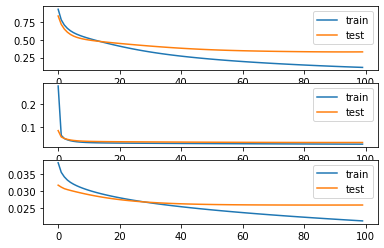

In [381]:
fig = plt.figure()
plt.subplot(3, 1, 1)
plt.plot(history_1.history['loss'], label='train')
plt.plot(history_1.history['val_loss'], label='test')
plt.legend();

plt.subplot(3, 1, 2)
plt.plot(history_2.history['loss'], label='train')
plt.plot(history_2.history['val_loss'], label='test')
plt.legend();

plt.subplot(3, 1, 3)
plt.plot(history_3.history['loss'], label='train')
plt.plot(history_3.history['val_loss'], label='test')
plt.legend();

In [382]:
trainy_centre_1 = trainy_centre_1.reshape(1,-1)
testy_centre_1 = testy_centre_1.reshape(1,-1)

trainy_centre_2 = trainy_centre_2.reshape(1,-1)
testy_centre_2 = testy_centre_2.reshape(1,-1)

trainy_centre_3 = trainy_centre_3.reshape(1,-1)
testy_centre_3 = testy_centre_3.reshape(1,-1)

In [383]:
testPredict_centre_1 = model.predict(testx_centre_1)
testPredict_centre_1 = scaler.inverse_transform(testPredict_centre_1)
testy_centre_1 = scaler.inverse_transform(testy_centre_1)
trainPredict_centre_1 = model.predict(trainx_centre_1)
trainPredict_centre_1 = scaler.inverse_transform(trainx_centre_1)
trainy_centre_1 = scaler.inverse_transform(trainy_centre_1)

testPredict_centre_2 = model.predict(testx_centre_2)
trainPredict_centre_2 = model.predict(trainx_centre_2)
trainPredict_centre_2 = scaler.inverse_transform(trainx_centre_2)
testPredict_centre_2 = scaler.inverse_transform(testPredict_centre_2)
testy_centre_2 = scaler.inverse_transform(testy_centre_2)
trainy_centre_2 = scaler.inverse_transform(trainy_centre_2)

testPredict_centre_3 = model.predict(testx_centre_3)
trainPredict_centre_3 = model.predict(trainx_centre_3)
trainPredict_centre_3 = scaler.inverse_transform(trainx_centre_3)
testPredict_centre_3 = scaler.inverse_transform(testPredict_centre_3)
testy_centre_3 = scaler.inverse_transform(testy_centre_3)
trainy_centre_3 = scaler.inverse_transform(trainy_centre_3)

<Figure size 432x288 with 0 Axes>

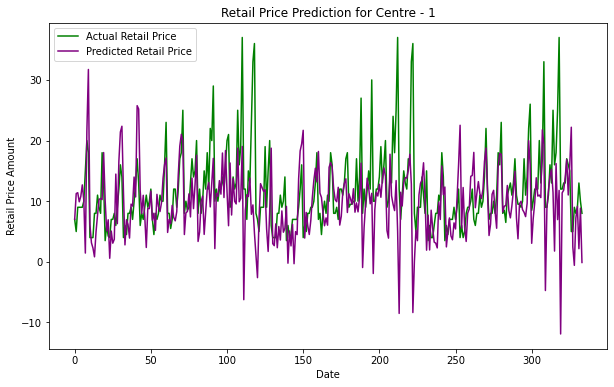

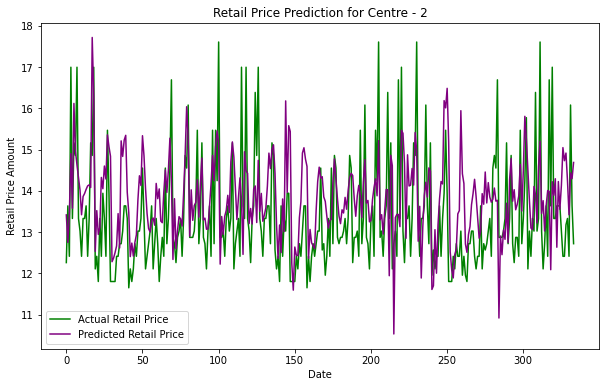

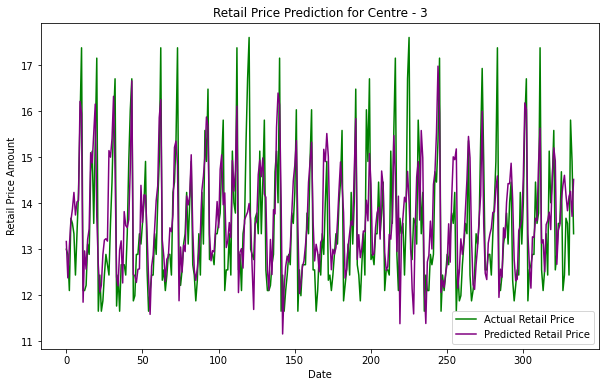

In [384]:
fig = plt.figure()
plt.figure(figsize=(10,6))
plt.plot(testy_centre_1[0], color='green', label='Actual Retail Price')
plt.plot(testPredict_centre_1 , color='purple', label='Predicted Retail Price')
plt.title('Retail Price Prediction for Centre - 1')
plt.xlabel('Date')
plt.ylabel('Retail Price Amount')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(testy_centre_2[0], color='green', label='Actual Retail Price')
plt.plot(testPredict_centre_2 , color='purple', label='Predicted Retail Price')
plt.title('Retail Price Prediction for Centre - 2')
plt.xlabel('Date')
plt.ylabel('Retail Price Amount')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(testy_centre_3[0], color='green', label='Actual Retail Price')
plt.plot(testPredict_centre_3 , color='purple', label='Predicted Retail Price')
plt.title('Retail Price Prediction for Centre - 3')
plt.xlabel('Date')
plt.ylabel('Retail Price Amount')
plt.legend()
plt.show()

In [385]:
# trainscore = math.sqrt(mean_squared_error(trainy_centre_1[0], trainPredict_centre_1[:,0]))
# testscore = math.sqrt(mean_squared_error(testy_centre_1[0], testPredict_centre_1[:,0]))
# print("Train MSE: {}, Test MSE: {}".format(trainscore, testscore))

# trainscore = math.sqrt(mean_squared_error(trainy_centre_1[0], trainPredict_centre_1[:,0]))
# testscore = math.sqrt(mean_squared_error(testy_centre_1[0], testPredict_centre_1[:,0]))
# print("Train MSE for centre 1 model : {}, Test MSE: {}".format(trainscore, testscore))

# trainscore = math.sqrt(mean_squared_error(trainy_centre_2[0], trainPredict_centre_2[:,0]))
# testscore = math.sqrt(mean_squared_error(testy_centre_2[0], testPredict_centre_2[:,0]))
# print("Train MSE for centre 2 model : {}, Test MSE: {}".format(trainscore, testscore))

# trainscore = math.sqrt(mean_squared_error(trainy_centre_3[0], trainPredict_centre_3[:,0]))
# testscore = math.sqrt(mean_squared_error(testy_centre_3[0], testPredict_centre_3[:,0]))
# print("Train MSE for centre 3 model : {}, Test MSE: {}".format(trainscore, testscore))

In [386]:
print(trainy_centre_2[0], trainPredict_centre_2[:,0])

[12.413201 12.413201 13.634858 ... 12.718616 13.329444 15.161931] [[11.649665 13.329444 12.413201 ... 12.413201 11.955079 12.107786]
 [13.329444 12.413201 12.260493 ... 11.955079 12.107786 12.413201]
 [12.413201 12.260493 13.634858 ... 12.107786 12.413201 12.413201]
 ...
 [12.413201 12.718616 13.02403  ... 12.871323 13.02403  13.634858]
 [12.718616 13.02403  12.107786 ... 13.02403  13.634858 12.718616]
 [13.02403  12.107786 14.856517 ... 13.634858 12.718616 13.329444]]


# Predicting 90 days of 2015

In [387]:
#use retail price of last 30 days of 2014 to predict next 90 days

#centre-1
testPredict_centre_1 = []

x_data_centre_1 = testx_centre_1[-1] #get transformed retail price values of last 30 days 
x_centre_1 = np.reshape(x_data_centre_1,(1,1,30))
yhat = model.predict(x_centre_1)
testPredict_centre_1 = np.append(testPredict_centre_1,scaler.inverse_transform(yhat))
x_data_centre_1 = np.append(x_data_centre_1,yhat)

for i in range (89):
        x_data_centre_1 = x_data_centre_1[1:]
        x_centre_1 = np.reshape(x_data_centre_1,(1,1,30))
        yhat = model.predict(x_centre_1)
        testPredict_centre_1 = np.append(testPredict_centre_1,scaler.inverse_transform(yhat))
        x_data_centre_1 = np.append(x_data_centre_1,yhat)
        
#centre-2     
testPredict_centre_2 = []

x_data_centre_2 = testx_centre_2[-1] #get transformed retail price values of last 30 days 
x_centre_2 = np.reshape(x_data_centre_2,(1,1,30))
yhat = model.predict(x_centre_2)
testPredict_centre_2 = np.append(testPredict_centre_2,scaler.inverse_transform(yhat))
x_data_centre_2 = np.append(x_data_centre_2,yhat)

for i in range (89):
        x_data_centre_2 = x_data_centre_2[1:]
        x_centre_2 = np.reshape(x_data_centre_2,(1,1,30))
        yhat = model.predict(x_centre_2)
        testPredict_centre_2 = np.append(testPredict_centre_2,scaler.inverse_transform(yhat))
        x_data_centre_2 = np.append(x_data_centre_2,yhat)
        
#centre-3
testPredict_centre_3 = []

x_data_centre_3 = testx_centre_3[-1] #get transformed retail price values of last 30 days 
x_centre_3 = np.reshape(x_data_centre_3,(1,1,30))
yhat = model.predict(x_centre_3)
testPredict_centre_3 = np.append(testPredict_centre_3,scaler.inverse_transform(yhat))
x_data_centre_3 = np.append(x_data_centre_3,yhat)

for i in range (89):
        x_data_centre_3 = x_data_centre_3[1:]
        x_centre_3 = np.reshape(x_data_centre_3,(1,1,30))
        yhat = model.predict(x_centre_3)
        testPredict_centre_3 = np.append(testPredict_centre_3,scaler.inverse_transform(yhat))
        x_data_centre_3 = np.append(x_data_centre_3,yhat)
        


In [388]:
#Create Dataframe with predicted retail prices
centre_1_test_df = pd.DataFrame(columns = ['Date','Centre_Name','Predicted_Retail_Price'])
centre_1_test_df['Date']=pd.date_range(start='1/1/2015' ,end = '31/3/2015', freq='D')
centre_1_test_df['Centre_Name'] = "DELHI"
centre_1_test_df['Predicted_Retail_Price'] = testPredict_centre_1

#Create Dataframe with predicted retail prices
centre_2_test_df = pd.DataFrame(columns = ['Date','Centre_Name','Predicted_Retail_Price'])
centre_2_test_df['Date']=pd.date_range(start='1/1/2015' ,end = '31/3/2015', freq='D')
centre_2_test_df['Centre_Name'] = "KOLKATA"
centre_2_test_df['Predicted_Retail_Price'] = testPredict_centre_2

#Create Dataframe with predicted retail prices
centre_3_test_df = pd.DataFrame(columns = ['Date','Centre_Name','Predicted_Retail_Price'])
centre_3_test_df['Date']=pd.date_range(start='1/1/2015' ,end = '31/3/2015', freq='D')
centre_3_test_df['Centre_Name'] = "MUMBAI"
centre_3_test_df['Predicted_Retail_Price'] = testPredict_centre_3

test_df = pd.concat([centre_1_test_df , centre_2_test_df, centre_3_test_df],ignore_index=True)
test_df

,Date,Centre_Name,Predicted_Retail_Price
0,2015-01-01,DELHI,-0.105332
1,2015-01-02,DELHI,2.228311
2,2015-01-03,DELHI,1.624950
3,2015-01-04,DELHI,3.127767
4,2015-01-05,DELHI,10.789733
...,...,...,...
265,2015-03-27,MUMBAI,16.181450
266,2015-03-28,MUMBAI,16.238626
267,2015-03-29,MUMBAI,16.269686
268,2015-03-30,MUMBAI,16.244585


In [389]:
test_df.to_csv('lstm_price_prediction_potato.csv',index=False)